# SEGMENTING AND CLUSTERING NEIGHBORHOODS IN TORONTO

## 1. Canada Postal Codes Dataframe

The requirements, that Canada Postal Codes Dataframe should meet, are written as comments.

Every requirement is fullfiled in a separate Notebook cell.

In [1]:
!pip install bs4
!conda install -c conda-forge folium=0.5.0 --yes 
!pip install pandas==1.0.3

Solving environment: done

# All requested packages already installed.

  Using cached pandas-1.0.3-cp37-cp37m-manylinux1_x86_64.whl (10.0 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.3
    Uninstalling pandas-1.2.3:
      Successfully uninstalled pandas-1.2.3


In [2]:
!pip install --upgrade pandas

  Using cached pandas-1.2.3-cp37-cp37m-manylinux1_x86_64.whl (9.9 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.3
    Uninstalling pandas-1.0.3:
      Successfully uninstalled pandas-1.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibm-watson-machine-learning 1.0.53 requires pandas<=1.0.5, but you have pandas 1.2.3 which is incompatible.


In [3]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library
from bs4 import BeautifulSoup
print('Libraries imported.')

Libraries imported.


In [4]:
# Use pandas to transform the data in the table on the Wikipedia page into the pandas dataframe
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
dataframe_list = pd.read_html(url, flavor='bs4')
dataframe = dataframe_list[0]
dataframe.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [5]:
# The dataframe should consist of three columns: PostalCode, Borough, and Neighborhood
dataframe_col = dataframe.rename(columns = {'Postal Code' : 'PostalCode', 'Neighbourhood' : 'Neighborhood'})
dataframe_col.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [6]:
# Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned
print('Number of rows in table, where Borough is not assigned: \n', len(dataframe_col[dataframe_col['Borough'] == 'Not assigned']))
dataframe_assigned = dataframe_col[dataframe_col.Borough != 'Not assigned'].reset_index(drop=True)
print('Rows in table before we removed "Not assigned" Boroughs: \n', dataframe_col.count(), '\nRows in table after removal: \n', dataframe_assigned.count())

Number of rows in table, where Borough is not assigned: 
 77
Rows in table before we removed "Not assigned" Boroughs: 
 PostalCode      180
Borough         180
Neighborhood    180
dtype: int64 
Rows in table after removal: 
 PostalCode      103
Borough         103
Neighborhood    103
dtype: int64


In [7]:
# Rows should be combined into one row with the neighborhoods separated with a comma
print('All the Post codes are unique in the table (', dataframe_assigned['PostalCode'].nunique(), '), there is nothing to combine.')

All the Post codes are unique in the table ( 103 ), there is nothing to combine.


In [8]:
# If a cell has a borough but a Not assigned  neighborhood, then the neighborhood should be the same as the borough
print('There are no "Not assigned" neighborhoods in the table: \n', dataframe_assigned.isin(['Not assigned']).sum(axis=0))

There are no "Not assigned" neighborhoods in the table: 
 PostalCode      0
Borough         0
Neighborhood    0
dtype: int64


In [9]:
# In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe
dataframe_assigned.shape

(103, 3)

## 2. Geographical coordinates of the neighborhoods

Given that the Geocoder Python package can be very unreliable, I am going to use a csv file that has the geographical coordinates.

In [10]:
# read csv file with geographical coordinates into a dataframe
coord = pd.read_csv("https://cocl.us/Geospatial_data")
coord = coord.rename(columns = {'Postal Code' : 'PostalCode'})
coord.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
# make a dataframe of geographical coordinates of the neighborhoods in the Toronto
Postal_with_coord = pd.merge(dataframe_assigned, coord, on=["PostalCode"])
Postal_with_coord.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## 3. Explore and cluster the neighborhoods in Toronto

I will explain every step of this analysis as a comment in a separate Notebook cell.

In [12]:
# will work with only boroughs that contain the word Toronto
Toronto = Postal_with_coord[Postal_with_coord['Borough'].str.contains('Toronto')].reset_index(drop=True)
print('There are ',Toronto['Borough'].count(), ' Boroughs in Canada that contains word Toronto')
Toronto.head()

There are  39  Boroughs in Canada that contains word Toronto


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [13]:
# in order to define an instance of the geocoder, we need to define a user_agent:
address = 'Toronto, TOR'
geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.7370584, -79.2442535.


In [14]:
# will create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# will add markers to map
for lat, lng, borough, neighborhood in zip(Toronto['Latitude'], Toronto['Longitude'], Toronto['Borough'], Toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

# will show the map
print('This is a map of Toronto neighburhoods')
map_toronto

This is a map of Toronto neighburhoods


Will define Foursquare Credentials and Version below (sensitive code cell)

In [15]:
# @hidden_cell
CLIENT_ID = 'LNCKLABY1DEZOJNPD0JA200QJDKCGOLCDMJUW2NA010RCDVA' # your Foursquare ID
CLIENT_SECRET = 'EYRFXSLVQPKBD54I5C2V0O4BJKSE52G5RVODPMEII4FADD40' # your Foursquare Secret
VERSION = '20210305' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Let's create a function returns venues in 500m from Foursquare to all the neighborhoods in Toronto

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's create a dataframe of Toronto venues and see how many of them were returned

In [17]:
toronto_venues = getNearbyVenues(names = Toronto['Neighborhood'],
                                   latitudes = Toronto['Latitude'],
                                   longitudes = Toronto['Longitude']
                                  )
toronto_venues.groupby('Neighborhood').count()

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",24,24,24,24,24,24
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",17,17,17,17,17,17
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",15,15,15,15,15,15
Central Bay Street,59,59,59,59,59,59
Christie,15,15,15,15,15,15
Church and Wellesley,75,75,75,75,75,75
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,32,32,32,32,32,32


Let's find out how many unique categories can be curated from all the returned venues

In [18]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 230 uniques categories.


### Let's analyze each Neighbourhood

In [19]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighbourhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Next, let's group rows by neighbourhood and by taking the mean of the frequency of occurrence of each category

In [20]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.017241,0.000000,0.0,0.0,0.000000,0.0,0.0,0.017241,0.051724,0.000000,0.000000,0.0,0.017241,0.017241,0.0,0.034483,0.0,0.0,0.017241,0.0,0.000000,0.0,0.000000,0.0,0.017241,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.017241,0.0,0.0,0.0,0.034483,0.0,0.0,0.0,0.000000,0.017241,0.051724,0.086207,0.0,0.0,0.0,0.0,0.0,0.0,0.017241,0.000000,0.017241,0.000000,0.0,0.0,0.017241,0.0,0.0,0.0,0.0,0.017241,0.0,0.017241,0.000000,0.0,0.0,0.0,0.000000,0.0,0.017241,0.0,0.0,0.0,0.0,0.000000,0.034483,0.000000,0.0,0.0,0.017241,0.0,0.0,0.0,0.0,0.0,0.017241,0.017241,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [21]:
# let's confirm new size
print(toronto_onehot.shape)
print(toronto_grouped.shape)

(1602, 230)
(39, 230)


Let's write a function to sort the venues in descending order

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Let's create a dataframe with the top 10 venues for each neighborhood

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Pharmacy,Beer Bar,Farmers Market,Cheese Shop,Seafood Restaurant,Restaurant,French Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Nightclub,Grocery Store,Burrito Place,Climbing Gym,Convenience Store,Furniture / Home Store,Yoga Studio
2,"Business reply mail Processing Centre, South C...",Yoga Studio,Smoke Shop,Gym / Fitness Center,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Park,Pizza Place,Recording Studio
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Boutique,Airport Food Court,Coffee Shop,Harbor / Marina,Bar,Airport,Sculpture Garden
4,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Salad Place,Bubble Tea Shop,Thai Restaurant,Burger Joint,Japanese Restaurant,Discount Store


### Cluster Neighborhoods

Let's use an Elbow Method to find out, how many cluster we should use

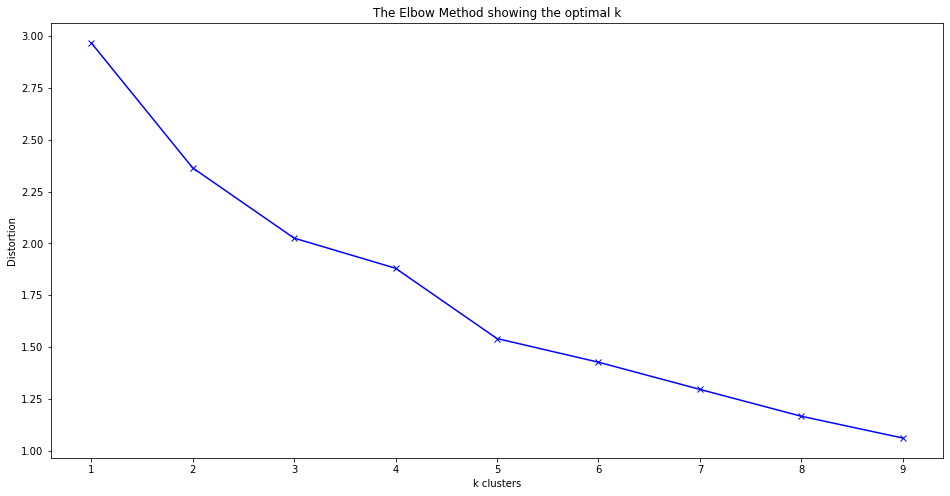

In [24]:
import matplotlib.pyplot as plt

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood',1)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Run k-means to cluster the neighborhood into 5 clusters

In [25]:
kclusters=5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [26]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = Toronto

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Park,Bakery,Theater,Café,Pub,Breakfast Spot,Yoga Studio,Farmers Market,Chocolate Shop
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Sushi Restaurant,College Cafeteria,Diner,Yoga Studio,Fried Chicken Joint,Café,College Auditorium,Creperie,Distribution Center
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Clothing Store,Coffee Shop,Hotel,Cosmetics Shop,Italian Restaurant,Japanese Restaurant,Café,Middle Eastern Restaurant,Bubble Tea Shop,Ramen Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Cocktail Bar,American Restaurant,Gastropub,Gym,Seafood Restaurant,Cosmetics Shop,Restaurant,Creperie
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Pub,Health Food Store,Asian Restaurant,Trail,Yoga Studio,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Miscellaneous Shop,Mexican Restaurant


Finally, let's visualize the resulting clusters

In [27]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's examine each cluster and determine the discriminating venue categories that distinguish each cluster

In [28]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Regent Park, Harbourfront",0,Coffee Shop,Park,Bakery,Theater,Café,Pub,Breakfast Spot,Yoga Studio,Farmers Market,Chocolate Shop
1,"Queen's Park, Ontario Provincial Government",0,Coffee Shop,Sushi Restaurant,College Cafeteria,Diner,Yoga Studio,Fried Chicken Joint,Café,College Auditorium,Creperie,Distribution Center
2,"Garden District, Ryerson",0,Clothing Store,Coffee Shop,Hotel,Cosmetics Shop,Italian Restaurant,Japanese Restaurant,Café,Middle Eastern Restaurant,Bubble Tea Shop,Ramen Restaurant
3,St. James Town,0,Coffee Shop,Café,Cocktail Bar,American Restaurant,Gastropub,Gym,Seafood Restaurant,Cosmetics Shop,Restaurant,Creperie
4,The Beaches,0,Pub,Health Food Store,Asian Restaurant,Trail,Yoga Studio,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Miscellaneous Shop,Mexican Restaurant
5,Berczy Park,0,Coffee Shop,Cocktail Bar,Bakery,Pharmacy,Beer Bar,Farmers Market,Cheese Shop,Seafood Restaurant,Restaurant,French Restaurant
6,Central Bay Street,0,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Salad Place,Bubble Tea Shop,Thai Restaurant,Burger Joint,Japanese Restaurant,Discount Store
7,Christie,0,Grocery Store,Café,Park,Italian Restaurant,Coffee Shop,Candy Store,Baby Store,Restaurant,Nightclub,Moroccan Restaurant
8,"Richmond, Adelaide, King",0,Coffee Shop,Café,Restaurant,Thai Restaurant,Deli / Bodega,Clothing Store,Bakery,Gym,Hotel,Lounge
9,"Dufferin, Dovercourt Village",0,Pharmacy,Bakery,Pet Store,Park,Music Venue,Café,Middle Eastern Restaurant,Brewery,Supermarket,Bar


In [29]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,"Moore Park, Summerhill East",1,Restaurant,Park,Trail,Movie Theater,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant
33,Rosedale,1,Park,Playground,Trail,Yoga Studio,Movie Theater,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant


In [30]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,"Forest Hill North & West, Forest Hill Road Park",2,Mexican Restaurant,Trail,Jewelry Store,Sushi Restaurant,Yoga Studio,Moroccan Restaurant,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store


In [31]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Lawrence Park,3,Park,Bus Line,Swim School,Yoga Studio,Moroccan Restaurant,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant


In [32]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Roselawn,4,Health & Beauty Service,Home Service,Garden,Yoga Studio,Movie Theater,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant


Let's rename Cluster Labels

In [33]:
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].replace({0 : 'Most visit Cafes, Restaurants, Bars',
                                                                             1 : 'Most visit Park, Playground, Trail',
                                                                             2 : 'Most visit Jewelry store',
                                                                             3 : 'Most visit Park, Bus Line, Swim School',
                                                                             4 : 'Most visit Health and Beauty Service'
                                                                            })